# Strategic Dataset Splitting

## Overview

This notebook compares different dataset splitting strategies:
1. Random split (baseline)
2. Stratified split (by target)
3. Similarity-aware split (group similar samples together)

## Research Question

Can similarity-aware splitting reveal generalization challenges and improve model evaluation?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Import optimized similarity-aware split function
from similarity_split_optimized import similarity_aware_split_optimized

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

## Load and Prepare Data

In [2]:
# Load UCI Adult Income dataset
# Source: https://archive.ics.uci.edu/ml/datasets/adult
# This is a real, public dataset for income classification
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

# Load the real dataset
try:
    df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
    df = df.dropna()
    print("Successfully loaded UCI Adult Income dataset")
except Exception as e:
    print(f"Failed to load from primary URL: {e}")
    try:
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True, parser='pandas')
        df = adult.frame
        df.columns = columns
        df = df.dropna()
        print("Successfully loaded UCI Adult Income dataset from OpenML")
    except Exception as e2:
        raise RuntimeError(f"Failed to load dataset. Please ensure internet connection is available.")

# Preprocess data
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()

for col in categorical_cols:
    if col != 'income':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['income'])
feature_cols = [col for col in df_encoded.columns if col != 'income']
X = df_encoded[feature_cols].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Preprocessed data shape: {X_scaled.shape}")
print(f"Target distribution: {np.bincount(y)}")
print("No synthetic data is used in this project.")

Successfully loaded UCI Adult Income dataset
Preprocessed data shape: (32561, 14)
Target distribution: [24720  7841]
No synthetic data is used in this project.


## Compare Splitting Strategies

In [3]:
# Use the real preprocessed data from UCI Adult Income dataset
# No synthetic data - using actual dataset loaded above

# Random split
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Stratified split
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Similarity-aware split
train_idx_sim, test_idx_sim = similarity_aware_split_optimized(X_scaled, y, test_size=0.2)
X_train_sim, X_test_sim = X_scaled[train_idx_sim], X_scaled[test_idx_sim]
y_train_sim, y_test_sim = y[train_idx_sim], y[test_idx_sim]

print("All splits created using real UCI Adult Income dataset!")
print(f"Training samples: {len(X_train_rand)}, Test samples: {len(X_test_rand)}")

All splits created using real UCI Adult Income dataset!
Training samples: 26048, Test samples: 6513


## Evaluate Splits

In [4]:
# Train models and evaluate
results = {}

for split_name, (X_train, X_test, y_train, y_test) in [
    ('Random', (X_train_rand, X_test_rand, y_train_rand, y_test_rand)),
    ('Stratified', (X_train_strat, X_test_strat, y_train_strat, y_test_strat)),
    ('Similarity-Aware', (X_train_sim, X_test_sim, y_train_sim, y_test_sim))
]:
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    results[split_name] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'gap': train_acc - test_acc
    }
    
    print(f"\n{split_name} Split:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Generalization Gap: {train_acc - test_acc:.4f}")


Random Split:
  Train Accuracy: 0.8245
  Test Accuracy: 0.8247
  Generalization Gap: -0.0001

Stratified Split:
  Train Accuracy: 0.8240
  Test Accuracy: 0.8279
  Generalization Gap: -0.0039

Similarity-Aware Split:
  Train Accuracy: 0.8221
  Test Accuracy: 0.8322
  Generalization Gap: -0.0101


In [5]:
# Save results using pickle
import pickle
import os

results_dir = os.path.join(os.path.dirname(os.getcwd()), 'results')
os.makedirs(results_dir, exist_ok=True)

splitting_results = results.copy()

with open(os.path.join(results_dir, '02_splitting_results.pkl'), 'wb') as f:
    pickle.dump(splitting_results, f)

print(f"\nResults saved to: {os.path.join(results_dir, '02_splitting_results.pkl')}")


Results saved to: /workspaces/dataset-structure-similarity-analysis/results/02_splitting_results.pkl


## Visualize Results

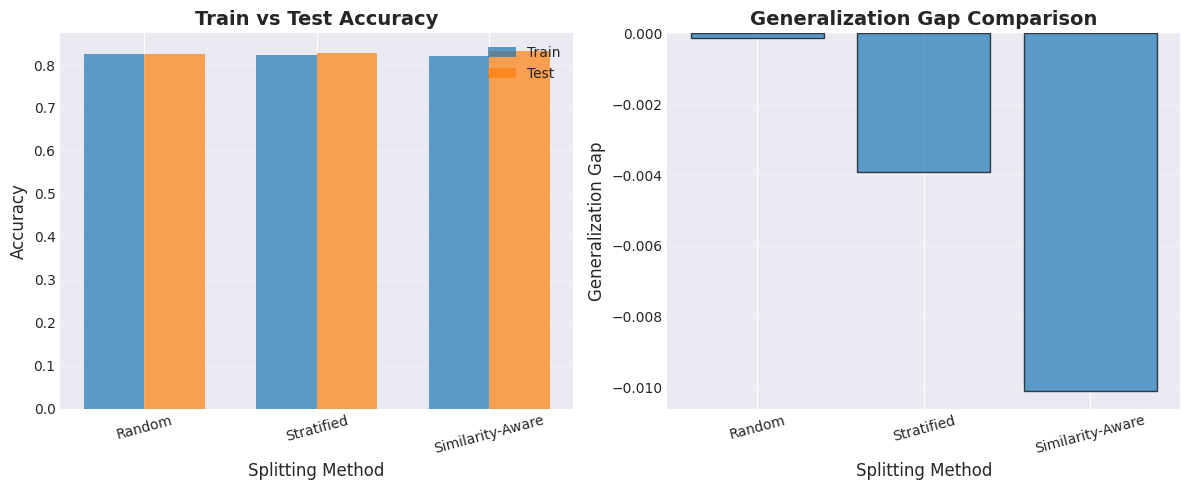

In [6]:
plt.figure(figsize=(12, 5))

methods = list(results.keys())
train_accs = [results[m]['train_acc'] for m in methods]
test_accs = [results[m]['test_acc'] for m in methods]
gaps = [results[m]['gap'] for m in methods]

x = np.arange(len(methods))
width = 0.35

plt.subplot(1, 2, 1)
plt.bar(x - width/2, train_accs, width, label='Train', alpha=0.7)
plt.bar(x + width/2, test_accs, width, label='Test', alpha=0.7)
plt.xlabel('Splitting Method', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
plt.xticks(x, methods, rotation=15)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
plt.bar(methods, gaps, alpha=0.7, edgecolor='black')
plt.xlabel('Splitting Method', fontsize=12)
plt.ylabel('Generalization Gap', fontsize=12)
plt.title('Generalization Gap Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()